In [1]:
import pandas as pd
import string

In [2]:
df = pd.read_csv('srpski.csv', sep='\t')
df = df.drop(columns=['Rbr', 'SR', 'sr/sr', 'Naslov', 'Jezik'])

In [3]:
for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = df[column].str.lower()

In [4]:
import classla

In [5]:
classla.download('sr')

2023-12-26 22:17:05 INFO: Downloading these customized packages for language: sr (Serbian)...
| Processor | Package  |
------------------------
| tokenize  | standard |
| pos       | standard |
| lemma     | standard |
| depparse  | standard |
| ner       | standard |
| pretrain  | standard |

2023-12-26 22:19:13 INFO: Finished downloading models and saved to /home/milica/classla_resources.


In [6]:
nlp = classla.Pipeline("sr",  processors='tokenize,lemma,pos')

2023-12-26 22:19:13 INFO: Loading these models for language: sr (Serbian):
| Processor | Package  |
------------------------
| tokenize  | standard |
| pos       | standard |
| lemma     | standard |

2023-12-26 22:19:13 INFO: Use device: cpu
2023-12-26 22:19:13 INFO: Loading: tokenize


2023-12-26 22:19:13 INFO: Loading: pos
2023-12-26 22:19:16 INFO: Loading: lemma
2023-12-26 22:19:36 INFO: Done loading processors!


In [7]:
def process_text(text):
    doc = nlp(text)
    
    lemmas = [word.lemma for sent in doc.sentences for word in sent.words]
    
    return lemmas

df['Procesiran tekst'] = df['Tekst'].apply(process_text)


In [8]:
from nltk import FreqDist

In [9]:
def remove_punctuation(words):
    punctuation = string.punctuation
    punctuation_additional = ['``', "'", "''",'...','—',"-",';', ':',"“", "„", ".."]
    words_without_punct = [word for word in words if word not in punctuation and word not in punctuation_additional] 
    return words_without_punct

df['Procesiran tekst'] = df['Procesiran tekst'].apply(remove_punctuation)

In [10]:
all_words = [word for words in df['Procesiran tekst'] for word in words]
fdist = FreqDist(all_words)
def remove_freq_words(words):
    fw_words = fdist.most_common(100)
    freq_words = [word for word,count in fw_words if count > 100 or len(word) in (1,2)]
    words_without_punct = [word for word in words if word not in freq_words] 
    return words_without_punct

df['Procesiran tekst'] = df['Procesiran tekst'].apply(remove_freq_words)

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [12]:
author_texts = df['Procesiran tekst'].apply(' '.join)
vectorizer = TfidfVectorizer(max_features=3000)
tf_matrix = vectorizer.fit_transform(author_texts)
tf_df = pd.DataFrame(tf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
tf_df

,1938,ah,ajduk,ako,ala,aleks,amo,ana,anđeo,ao,...,žmurka,žrtva,žuboriti,žudan,žudeti,žuditi,žudno,žulj,žut,žutilo
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
134,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
135,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
136,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
X_train, X_test, y_train, y_test = train_test_split(tf_matrix, df['Autor'], test_size=0.2, random_state=42, stratify=df['Autor'])

In [14]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline

In [15]:
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

gb_classifier = GradientBoostingClassifier()

grid_search = GridSearchCV(gb_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print("Best Hyperparameters:", best_params)


Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


In [16]:
model = GradientBoostingClassifier(learning_rate=0.1,max_depth=3,min_samples_split=5, min_samples_leaf=4, n_estimators=100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
report_gradient = accuracy_score(y_test, y_pred)
report_gradient

0.32142857142857145

In [17]:
from sklearn.ensemble import RandomForestClassifier
model1 = RandomForestClassifier(max_depth=5,min_samples_split=15, n_estimators=300)
model1.fit(X_train, y_train)
y_pred = model1.predict(X_test)
report_forest = accuracy_score(y_test, y_pred)
report_forest

0.10714285714285714

In [18]:
classifierMB = MultinomialNB()
classifierMB.fit(X_train,y_train)
y_pred = classifierMB.predict(X_test)
y_pred_train = classifierMB.predict(X_train)
report_multinomial = accuracy_score(y_test, y_pred)
report1 = accuracy_score(y_train, y_pred_train)
report_multinomial


0.21428571428571427

In [19]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV



In [20]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'sigmoid']
}

svc = SVC()

grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train,y_train)

best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'C': 10, 'kernel': 'sigmoid'}


In [21]:
svm_model = SVC(kernel='sigmoid', C=10, coef0=1.0, gamma='scale')  # You can adjust the kernel and other hyperparameters

svm_model.fit(X_train, y_train)

SVC(C=10, coef0=1.0, kernel='sigmoid')

In [22]:
y_pred = svm_model.predict(X_test)
accuracy_svc = accuracy_score(y_test, y_pred)
accuracy_svc

0.4642857142857143

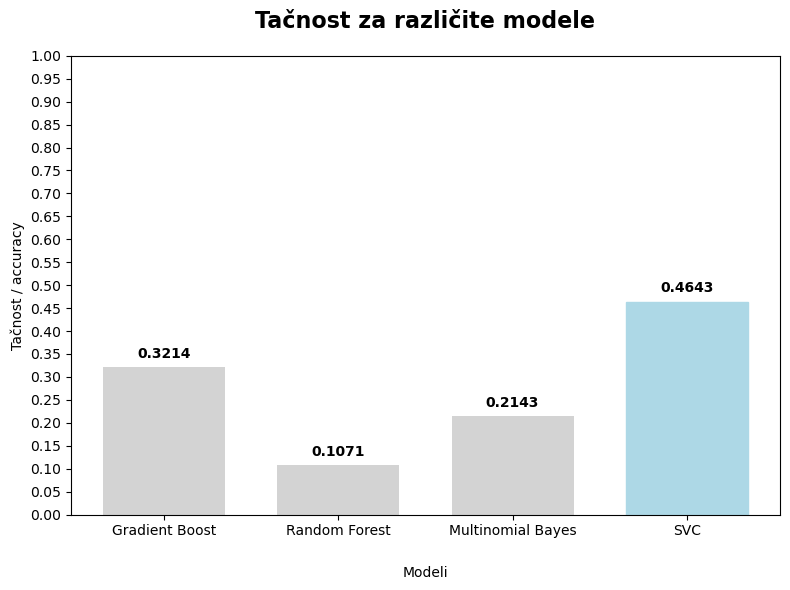

In [46]:
import matplotlib.pyplot as plt

modeli = ['Gradient Boost', 'Random Forest', 'Multinomial Bayes', 'SVC']

accuracy_scores = [report_gradient,report_forest,report_multinomial,accuracy_svc]
plt.figure(figsize=(8, 6))
bars = plt.bar(modeli, accuracy_scores, width=0.7, color=['lightgray', 'lightgray', 'lightgray','lightgray'])

plt.xlabel('Modeli',labelpad=20)
plt.ylabel('Tačnost / accuracy')
plt.title('Tačnost za različite modele',fontsize=16, fontweight='bold', pad=20)
plt.ylim([0, 1])  
plt.yticks([i/100 for i in range(0, 101, 5)])
max_index = accuracy_scores.index(max(accuracy_scores))
bars[max_index].set_color('lightblue')
for i, v in enumerate(accuracy_scores):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center', color='black', fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
param_grid = {
    'C': [0.1, 1, 10,20],
    'kernel': ['sigmoid'],
    'gamma': ['scale', 'auto'],
    'coef0': [0.0, 1.0],
}

svc = SVC()

grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train,y_train)

best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'C': 10, 'coef0': 1.0, 'gamma': 'scale', 'kernel': 'sigmoid'}
